# Diversity Analysis

In this notebook we'll use the output of our QIIME2 workflow to investigate alpha and beta diversity of samples in the meta-analysis. 

In [2]:
from utils import *
import pandas as pd
import qiime2 as q2
from plotnine import *
import skbio
import scipy.stats
import numpy as np
import os

%matplotlib inline

## Merged Table
First, we'll need to build a QIIME2 table that combines all our samples. We could use the QIIME2 merge tool, but as we have duplicated study IDs across URT sampling sites, we'll instead build a table ourselves. 

In [3]:
collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]
manifest_NP = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/NP/NP_manifest.csv',index_col= 0, header = None)
res = pd.DataFrame()
for file_name in manifest_NP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'NP'
    ab['study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
manifest_OP = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/OP/OP_manifest.csv',index_col= 0, header = None)
for file_name in manifest_OP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'OP'
    ab['study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
res = res.dropna(subset = ['genus']) #filter data 
res = res[~(res.genus.str.contains('None'))&~(res.genus.str.contains('uncultured'))&
          ~(res.genus.str.contains('Chloroplast'))&~(res.family.str.contains('Mitochondria'))]
res = clr(filter_taxa(res, min_reads=2, min_prevalence=0.05)) #center-log-ratio transformation and filtering
conditions = pd.read_csv('/proj/gibbons/nbohmann/metabug/conditions.csv',index_col = 0,header = None)[1].to_dict()
res['disease'] = res['study'].map(conditions)
res.head()

FileNotFoundError: [Errno 2] No such file or directory: 'qiime/PRJEB14780_table.qza'

We'll pivot this table, and save it as a QIIME2 artifact. 

In [3]:
res_pvt = pd.pivot_table(res, index = 'full_taxonomy', 
                         columns = 'sample_id', values = 'reads').fillna(0)
res_pvt = res_pvt.T
abundance_artifact = q2.Artifact.import_data("FeatureTable[Frequency]", res_pvt)
abundance_artifact.save('/proj/gibbons/nbohmann/metabug/manifest/merged_table.qza')

'merged_table.qza'

## Metadata
We'll also need a merged metadata table, constructed from study specific metadata

In [50]:
meta_list_NP = os.listdir('/proj/gibbons/nbohmann/metabug/manifest/NP/metadata')
meta_list_OP = os.listdir('/proj/gibbons/nbohmann/metabug/manifest/OP/metadata')
metadata = pd.DataFrame()
for file in meta_list_NP: 
    df = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/NP/metadata/'+file, sep = '\t')
    df['study'] = file.split('_')[0]
    metadata = pd.concat([metadata, df])
for file in meta_list_OP: 
    df = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/OP/metadata'+file, sep = '\t')
    df['study'] = file.split('_')[0]
    metadata = pd.concat([metadata, df])
metadata = metadata.drop_duplicates(subset = 'id')
metadata = metadata[metadata.id.isin(res.sample_id.unique())]
metadata.set_index('id', inplace = True)
metadata['condition'] = metadata['condition'].str.replace('non-control','control')
conditions = pd.read_csv('/proj/gibbons/nbohmann/metabug/conditions.csv',
                         index_col = 0,header = None)[1].to_dict()
metadata['disease'] = metadata['study'].map(conditions)
metadata['URT']  = metadata.index.map(res.set_index('sample_id')['URT'].to_dict())
metadata.to_csv('/proj/gibbons/nbohmann/metabug/manifest/merged_metadata.tsv', sep = '\t')

,condition,region,country,study,age,sex,disease,URT
id,,,,,,,,
ERR1529161,control,Europe,France,PRJEB14780,NaN,NaN,RSV,NP
ERR1529162,control,Europe,France,PRJEB14780,NaN,NaN,RSV,NP
ERR1529163,control,Europe,France,PRJEB14780,NaN,NaN,RSV,NP
ERR1529164,control,Europe,France,PRJEB14780,NaN,NaN,RSV,NP
ERR1529165,control,Europe,France,PRJEB14780,NaN,NaN,RSV,NP
...,...,...,...,...,...,...,...,...
SRR501810,case,Europe,Denmark,SRP013435,32.0,F,Tonsillitis,OP
SRR501811,case,Europe,Denmark,SRP013435,20.0,M,Tonsillitis,OP
SRR501812,case,Europe,Denmark,SRP013435,18.0,F,Tonsillitis,OP


And we'll save this as a .tsv

## Alpha Diversity

First, we'll look at alpha diversity using Shannon Entropy. We can do this in QIIME2 and pass in the merged table as an input. 

In [6]:
!qiime diversity alpha-rarefaction \
  --i-table merged_table.qza \
  --p-max-depth 10000 \
  --m-metadata-file merged_metadata.tsv \
  --o-visualization alpha-rarefaction.qzv

Saved Visualization to: alpha-rarefaction.qzv


In [7]:
!qiime feature-table rarefy \
  --i-table merged_table.qza \
  --p-sampling-depth 2000 \
  --o-rarefied-table rarefied_table.qza

Saved FeatureTable[Frequency] to: rarefied_table.qza


In [8]:
!qiime diversity alpha \
  --i-table rarefied_table.qza \
  --p-metric shannon \
  --o-alpha-diversity shannon.qza

Saved SampleData[AlphaDiversity] to: shannon.qza


We can build a QIIME2 visualization to quickly look at these data

In [9]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity shannon.qza \
    --m-metadata-file merged_metadata.tsv \
    --o-visualization shannon.qzv

Saved Visualization to: shannon.qzv


We'll also export the results to a directory so we can build our own visualizations

In [10]:
!qiime tools export \
  --input-path shannon.qza \
  --output-path shannon

Exported shannon.qza as AlphaDiversityDirectoryFormat to directory shannon


We'll map metadata to the results for our own visualizations

In [11]:
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/')
shannon = pd.read_csv('shannon/alpha-diversity.tsv', sep = '\t', index_col = 0)
shannon.index = shannon.index.rename('id')
shannon['region'] = shannon.index.map(metadata['region'].to_dict())
shannon['disease'] = shannon.index.map(metadata['disease'].to_dict())
shannon['condition'] = shannon.index.map(metadata['condition'].to_dict())
shannon['disease-condition'] = shannon['disease']+'-'+shannon['condition']
shannon['shannon_entropy'] = shannon['shannon_entropy'].astype('float')
shannon['URT'] = shannon.index.map(metadata['URT'].to_dict()).str.replace('NP','Nasopharynx').str.replace('OP','Oropharynx')
shannon

,shannon_entropy,region,disease,condition,disease-condition,URT
id,,,,,,
A111R,3.562521,Asia,Resp. Allergies,case,Resp. Allergies-case,Oropharynx
A143R,2.585905,Asia,Resp. Allergies,case,Resp. Allergies-case,Oropharynx
A155R,3.465369,Asia,Resp. Allergies,case,Resp. Allergies-case,Oropharynx
A165R,3.386024,Asia,Resp. Allergies,case,Resp. Allergies-case,Oropharynx
A180R,3.235540,Asia,Resp. Allergies,case,Resp. Allergies-case,Oropharynx
...,...,...,...,...,...,...
SRR9975231,3.811172,Asia,Tonsillitis,control,Tonsillitis-control,Oropharynx
SRR9975232,3.270137,Asia,Tonsillitis,control,Tonsillitis-control,Oropharynx
SRR9975233,3.467243,Asia,Tonsillitis,control,Tonsillitis-control,Oropharynx


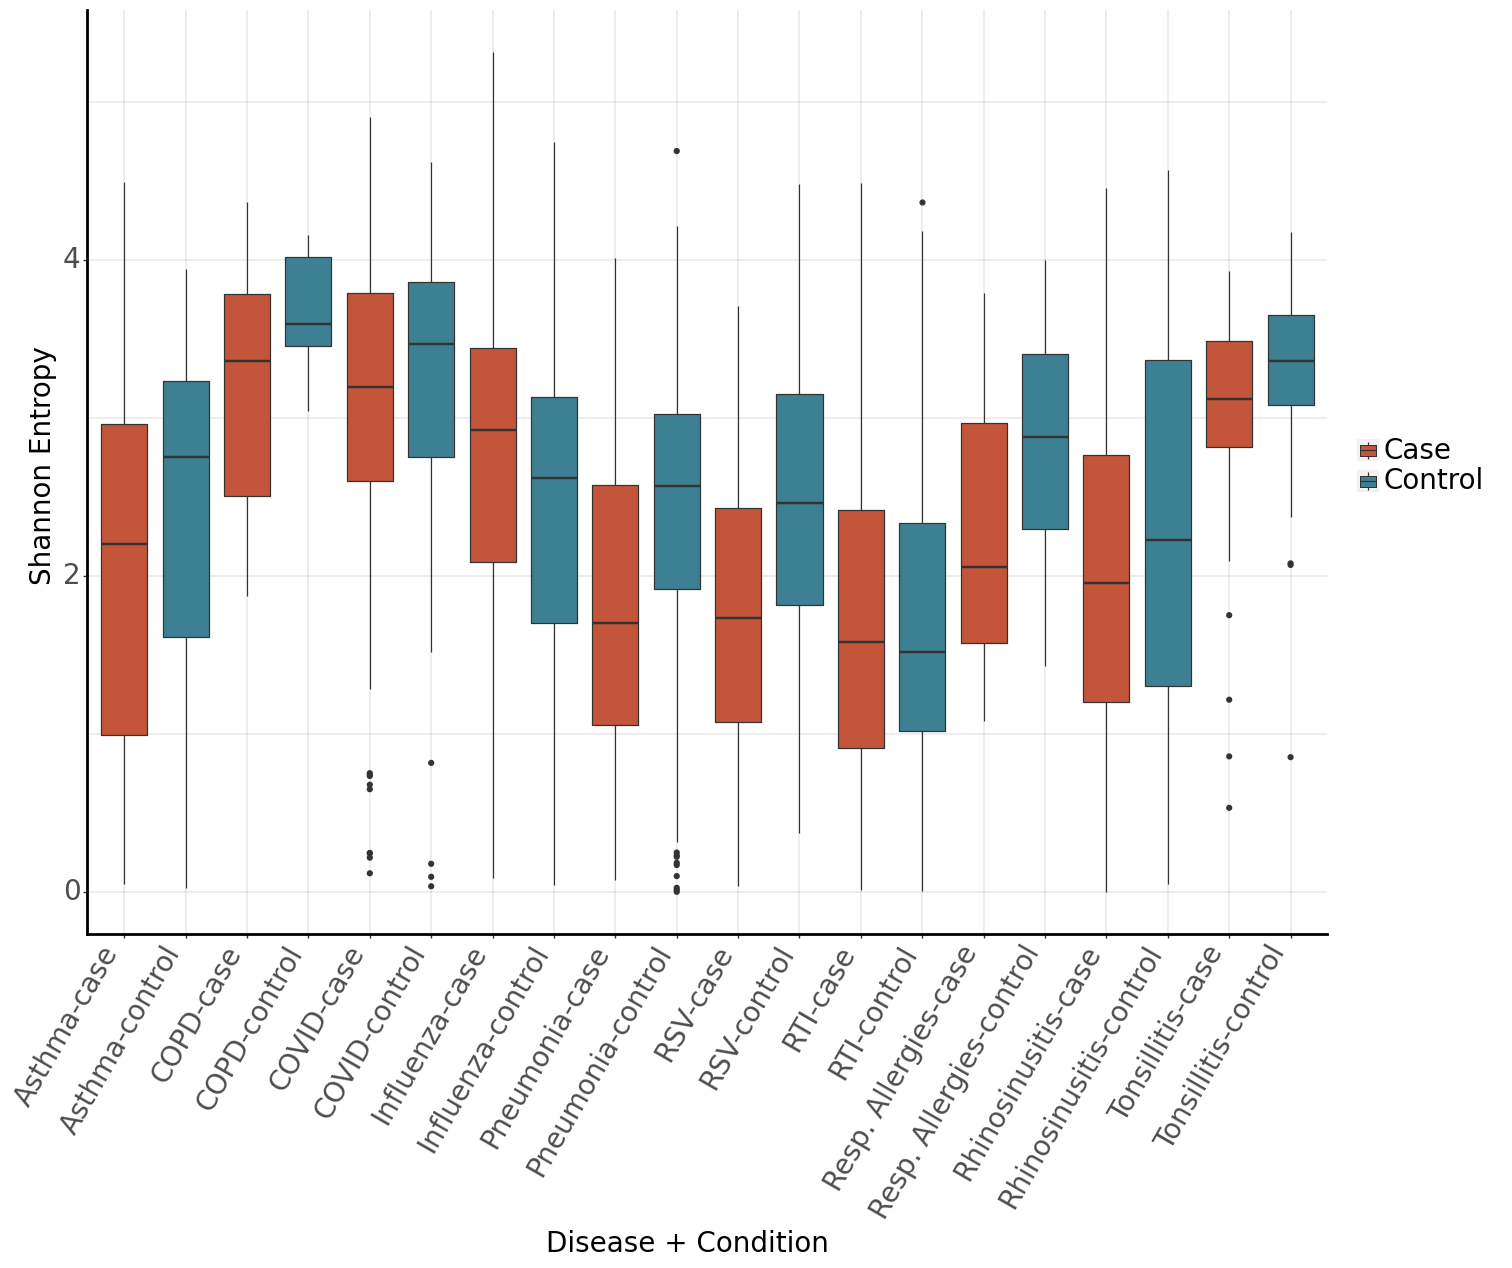

<ggplot: (8769382078040)>

In [98]:
shannon_plt = (ggplot(
    shannon, aes(x = 'disease-condition', y = 'shannon_entropy'))
    +geom_boxplot(aes(fill = 'condition'))
    +theme(axis_text_x=element_text(rotation=60, hjust=1))
    +scale_fill_manual(values = ['#c3553b','#3e8093'], labels = ['Case','Control'])
    +labs(x = 'Disease + Condition', y = 'Shannon Entropy', fill = 'Status')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right',
                                figure_size=(16, 12)))
shannon_plt

In [99]:
ggsave(shannon_plt, '/proj/gibbons/nbohmann/metabug/shannon.png',dpi = 300)

/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 12 in image.
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /proj/gibbons/nbohmann/metabug/shannon.png


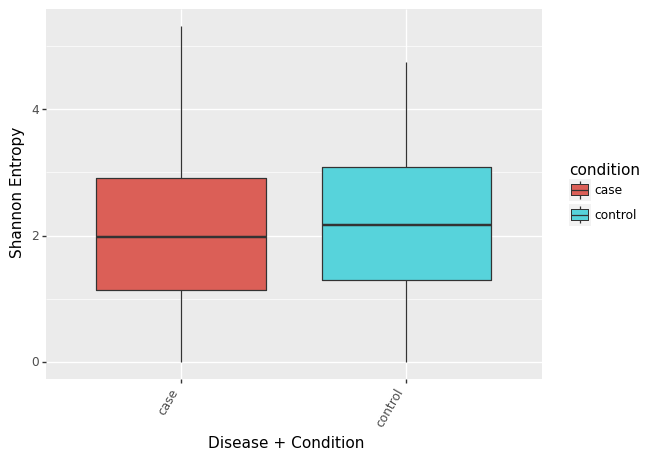

<ggplot: (8769948726754)>

In [13]:
shannon_plt = (ggplot(
    shannon, aes(x = 'condition', y = 'shannon_entropy'))
    +geom_boxplot(aes(fill = 'condition'))
    +theme(axis_text_x=element_text(rotation=60, hjust=1))
    +labs(x = 'Disease + Condition', y = 'Shannon Entropy')
              )
shannon_plt

In [14]:
for disease in shannon['disease'].unique():
    case = shannon['shannon_entropy'][(shannon['disease'].str.contains(disease))&
                                      (shannon['condition'].str.contains('case'))]
    control = shannon['shannon_entropy'][(shannon['disease'].str.contains(disease))&
                                      (shannon['condition'].str.contains('control'))]
    pval = scipy.stats.f_oneway(case,control)[1]
    print(disease+': '+pval.astype('str'))

Resp. Allergies: 0.00015716998663727676
RSV: 1.7820326233106938e-12
Asthma: 0.014349806671404007
Pneumonia: 1.5728266016756224e-10
Rhinosinusitis: 0.02214813560646703
RTI: 0.4437478169369642
COVID: 0.4387355532832037
Influenza: 0.0006325847171472321
Tonsillitis: 0.00031303611433319633
COPD: 0.07981284802494208


## Beta Diversity
Now we'll Look beta diversity among samples, by calculating Bray-Curtis dissimilarity

In [15]:
!qiime diversity beta \
    --i-table rarefied_table.qza \
    --p-metric braycurtis \
    --o-distance-matrix braycurtis.qza

Saved DistanceMatrix to: braycurtis.qza


Again, we'll export the artifact so we can use it for visualization

In [16]:
!qiime tools export \
  --input-path braycurtis.qza \
  --output-path braycurtis

Exported braycurtis.qza as DistanceMatrixDirectoryFormat to directory braycurtis


We'll read in our dissimilarity matrix, and conduct a PCoA in SkBio 

In [51]:
dm = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/braycurtis/distance-matrix.tsv', sep = '\t',index_col = 0)

In [52]:
od_res = skbio.stats.ordination.pcoa(dm)

/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -12.768272412436104 and the largest is 413.3043959531358.


In [53]:
od_res.proportion_explained

PC1       0.202879
PC2       0.100736
PC3       0.090755
PC4       0.076556
PC5       0.059916
            ...   
PC4530    0.000000
PC4531    0.000000
PC4532    0.000000
PC4533    0.000000
PC4534    0.000000
Length: 4534, dtype: float64

Now we can merge our PCoA results with corresponding metadata, and examine the proportion explained. 

In [54]:
od_res.samples.index = dm.index
metadata = metadata[metadata.index.isin(od_res.samples.index)]
od_res.samples['region'] = od_res.samples.index.map(metadata['region'].to_dict())
od_res.samples['age'] = od_res.samples.index.map(metadata['age'].to_dict())
od_res.samples['sex'] = od_res.samples.index.map(metadata['sex'].to_dict())
od_res.samples['URT'] = od_res.samples.index.map(metadata['URT'].to_dict()).str.replace('NP','Nasopharynx').str.replace('OP','Oropharynx')
od_res.samples['disease'] = od_res.samples.index.map(metadata['disease'].to_dict())
od_res.samples['country'] = od_res.samples.index.map(metadata['country'].to_dict())
od_res.samples['condition'] = od_res.samples.index.map(metadata['condition'].to_dict())
od_res.proportion_explained

PC1       0.202879
PC2       0.100736
PC3       0.090755
PC4       0.076556
PC5       0.059916
            ...   
PC4530    0.000000
PC4531    0.000000
PC4532    0.000000
PC4533    0.000000
PC4534    0.000000
Length: 4534, dtype: float64

Finally, we can plot the PCoA results. Again, testing different color encodings can be useful. 

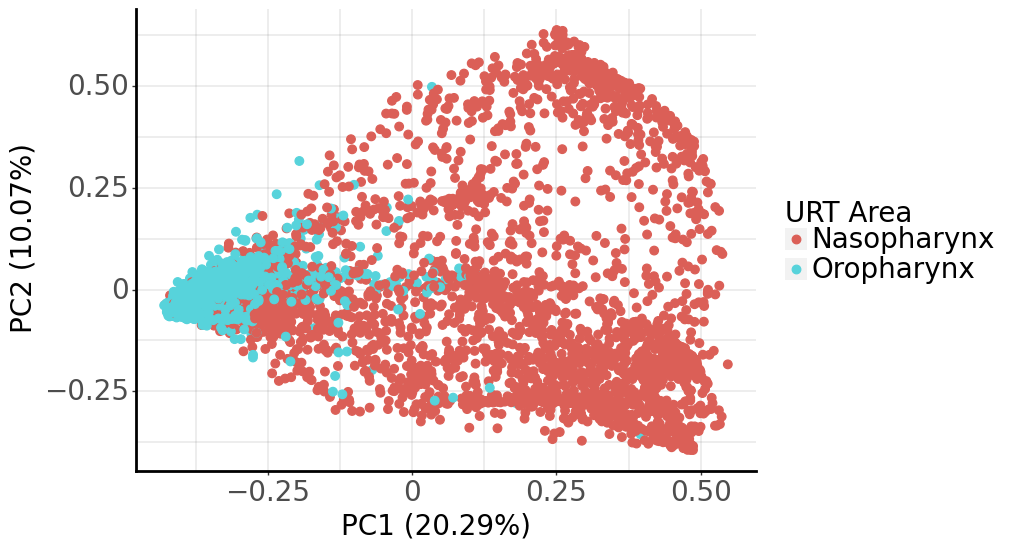

<ggplot: (8769382601689)>

In [96]:
plt = (ggplot(
    od_res.samples, aes(x = 'PC1', y = 'PC2', color = 'URT'))
    +geom_point(size = 3)
    +labs(x = 'PC1 (20.29%)', y = 'PC2 (10.07%)', color = 'URT Area')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_position='right',
                                figure_size=(8, 6)))
plt

In [97]:
ggsave(plt, '/proj/gibbons/nbohmann/metabug/notebooks/URT.png', dpi = 300)

/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /proj/gibbons/nbohmann/metabug/notebooks/URT.png


In [58]:
import pandas
import skbio
dm = pd.read_csv('/proj/gibbons/nbohmann/metabug/manifest/braycurtis/distance-matrix.tsv', sep = '\t',index_col = 0)
dm = skbio.stats.distance.DistanceMatrix(dm)
metadata_array= np.ascontiguousarray(metadata['URT'].to_list())
skbio.stats.distance.permanova(dm, grouping = metadata_array, permutations = 999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    4534
number of groups                  2
test statistic            87.447349
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [59]:
metadata_array= np.ascontiguousarray(metadata['condition'].to_list())
skbio.stats.distance.permanova(dm, grouping = metadata_array, permutations = 999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    4534
number of groups                  2
test statistic             8.473941
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [60]:
metadata_array= np.ascontiguousarray(metadata['region'].to_list())
skbio.stats.distance.permanova(dm, grouping = metadata_array, permutations = 999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    4534
number of groups                  6
test statistic            30.565684
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [61]:
metadata_array= np.ascontiguousarray(metadata['disease'].to_list())
skbio.stats.distance.permanova(dm, grouping = metadata_array, permutations = 999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    4534
number of groups                 10
test statistic            30.122952
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [76]:
metadata
france = (metadata['country'] == 'France')
control = (metadata['condition'] == 'control')
france[control]
control[france]

id
ERR1529161     True
ERR1529162     True
ERR1529163     True
ERR1529164     True
ERR1529165     True
              ...  
ERR1529608    False
ERR1529609    False
ERR1529610    False
ERR1529611    False
ERR1529612    False
Name: condition, Length: 235, dtype: bool

$P(A)$ is the probability of proposition $A$

$P(A~\mathrm{and}~B)$ is the probability of the conjunction of $A$ and $B$, that is, the probability that both are true.

$P(A | B)$ is the conditional probability of $A$ given that $B$ is true. The vertical line between $A$ and $B$ is pronounced “given”.

$$P(A|B) = \frac{P(A~\mathrm{and}~B)}{P(B)}$$

$$P(A~\mathrm{and}~B) = P(B) ~ P(A|B)$$



We have established that conjunction is commutative. In math notation, that means:

$$P(A~\mathrm{and}~B) = P(B~\mathrm{and}~A)$$

If we apply Theorem 2 to both sides, we have

$$P(B) P(A|B) = P(A) P(B|A)$$

Here’s one way to interpret that: if you want to check $A$ and $B$, you can do it in either order:

You can check $B$ first, then $A$ conditioned on $B$, or

You can check $A$ first, then $B$ conditioned on $A$.

If we divide through by $P(B)$, we get Theorem 3:

$$P(A|B) = \frac{P(A) P(B|A)}{P(B)}$$

In addition to these three theorems, there’s one more thing we’ll need to do Bayesian statistics: the law of total probability. Here’s one form of the law, expressed in mathematical notation:

$$P(A) = P(B_1 \mathrm{and} A) + P(B_2 \mathrm{and} A)$$

In words, the total probability of $A$ is the sum of two possibilities: either $B_1$ and $A$ are true or $B_2$ and $A$ are true. But this law applies only if $B_1$ and $B_2$ are:

In [80]:
from fractions import Fraction
test = Fraction(1,3)
test

Fraction(1, 3)